In [8]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import xarray as xr

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from copy import copy
import shapely.geometry as sgeom

In [4]:
from sat_tools import read_raster_stereographic

In [5]:
def _find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)], }
    return sgeom.LineString(points[side])


def _lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    def _te(xy):
        return xy[0]

    def _lc(t, n, b):
        return np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', _lc, _te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick)
                        for xtick in xticklabels])


def _lambert_yticks(ax, ticks):
    """Draw ticks on the left y-axis of a Lamber Conformal projection."""
    def _te(xy):
        return xy[1]

    def _lc(t, n, b):
        return np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', _lc, _te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick)
                        for ytick in yticklabels])


def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """
    Get the tick locations and labels for
    an axis of a Lambert Conformal projection.
    """
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().
                                     vertices.tolist())
    axis = _find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(),
                                                  xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [6]:
mapkw = dict(transform=ccrs.PlateCarree())

In [7]:
cc = plt.rcParams['axes.prop_cycle']

In [9]:
file_mask = 'core_masin_{flight_date:%Y%m%d}_r002_flight{flight_id}_1hz.nc'

In [10]:
filename = '../data/satellite/noaa19_avhrr_band2_vis_20180301_110931_mapping6_500.tif'

im, extent, crs = read_raster_stereographic(filename)

/local/fwv14jru/miniconda3/envs/IGP/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


In [11]:
sar_image_path = '../data/satellite/S1A_EW_GRDM_1SDH_20180308T082048_D339_N_1.tif'

In [12]:
projection = ccrs.Stereographic(central_latitude=68.5, central_longitude=-21)

In [13]:
xticks = list(np.arange(-180, 180, 5))
yticks = list(np.arange(0, 90, 1))

In [14]:
stride = 10

In [37]:
selected_flights = [*flights.keys()][2:-1]

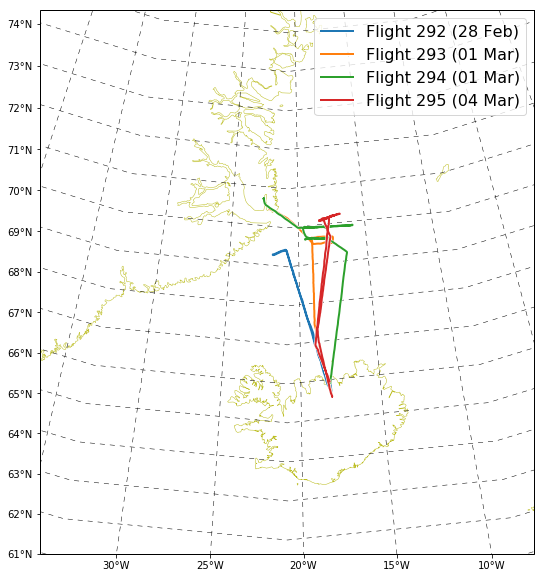

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=projection)
ax.set_extent([-34, -7.8, 61, 75.2])
# ax.set_extent([-25, -10, 67, 72])

ax.coastlines(resolution='10m', color='C8', linewidth=0.5)

# gl = ax.gridlines(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')

# h = ax.imshow(im[::stride, ::stride], origin='upper', extent=extent, transform=crs, cmap='gray_r', interpolation='nearest')

for i, (flight_id, color) in enumerate(zip(selected_flights, cc)):
    flight_date = datetime.strptime(flights[flight_id], '%Y%m%d')
    file_path = Path('../../../data') / file_mask.format(**locals())
    ds = xr.open_dataset(file_path, decode_times=False)
    ax.plot(ds.LON_OXTS, ds.LAT_OXTS, linestyle='-', linewidth=2, **mapkw, **color, label=f'Flight {flight_id} ({flight_date:%d %b})',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='w')])
ax.legend(fontsize=16, loc=1)

fig.canvas.draw()

ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle=(0, (10, 10)), linewidth=0.5, color='k')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
_lambert_xticks(ax, xticks)
_lambert_yticks(ax, yticks)

In [41]:
outdir = Path('.').absolute().parent / 'figures'
outdir.mkdir(exist_ok=True)

In [42]:
fig.savefig(outdir / f'flights_map_{selected_flights[0]}-{selected_flights[-1]}.png', dpi=300, bbox_inches='tight')

In [28]:
flight_date = datetime(2018,3,5)

In [29]:
np.array([flight_date + timedelta(seconds=int(i)) for i in ds.Time.values])

array([datetime.datetime(2018, 3, 5, 12, 19, 47),
       datetime.datetime(2018, 3, 5, 12, 19, 48),
       datetime.datetime(2018, 3, 5, 12, 19, 49), ...,
       datetime.datetime(2018, 3, 5, 13, 17, 2),
       datetime.datetime(2018, 3, 5, 13, 17, 3),
       datetime.datetime(2018, 3, 5, 13, 17, 4)], dtype=object)

In [62]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection=projection)
ax.set_extent([-34, -7.8, 61, 75.2])
ax.coastlines(resolution='10m', color='C8', linewidth=0.5)
gl = ax.gridlines(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')
h = ax.imshow(im[::stride, ::stride], origin='upper', extent=extent, transform=crs, cmap='gray', interpolation='nearest')

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, linewidth=3,
                    norm=plt.Normalize(z.min(), z.max()), **mapkw)
lc.set_array(z)
h = ax.add_collection(lc)
cb = fig.colorbar(h, ax=ax, shrink=0.8)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Altitude (m)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x, y, z, linewidth=2)
ax2.tick_params(labelsize=20)
ax2.set_zlabel('Altitude (m)', labelpad=20, fontsize=14)
ax2.set_xlabel('Longitude', labelpad=20, fontsize=14)
ax2.set_ylabel('Latitude', labelpad=20, fontsize=14)

ax2.view_init(90)

FigureCanvasNbAgg()

In [6]:
ds = xr.open_dataset(file_path, decode_times=False)

In [7]:
flight_time = np.array([flight_date + timedelta(seconds=int(i)) for i in ds.Time.values])

In [8]:
flight_time

array([datetime.datetime(2018, 3, 4, 0, 0, 34),
       datetime.datetime(2018, 3, 4, 0, 0, 35),
       datetime.datetime(2018, 3, 4, 0, 0, 36), ...,
       datetime.datetime(2018, 3, 4, 15, 9, 1),
       datetime.datetime(2018, 3, 4, 15, 9, 2),
       datetime.datetime(2018, 3, 4, 15, 9, 3)], dtype=object)